# test 3


In [1]:
import re,os,glob
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from collections import defaultdict
import numpy as np
# re patterns
base_save_dir="results/throughput/"
base_save_dir_thesis="../latex/results/"
base_dir=os.path.join("data/throughput/10k_complete")

matching_files = glob.glob(f"{base_dir}/*")

file_pattern= r'(\w+)_(\w+)_tT(\d+)_(\d+).data'

pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'

protocols=["udp","udpM","shm","tcp"]
sequence=[1,5,10,15,20,25,30,35,40]

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

Difference r507c02n02 - r507c01n03 :(0, 227363132.19)
r507c02n02: (2135776, 622624310)
r507c01n03: (2135776,849987442.19)

### time skew

['r507c01n03', 'r507c02n02']
-1 -1.0
0.772637996 0.772635811
2.1850000000434022e-06


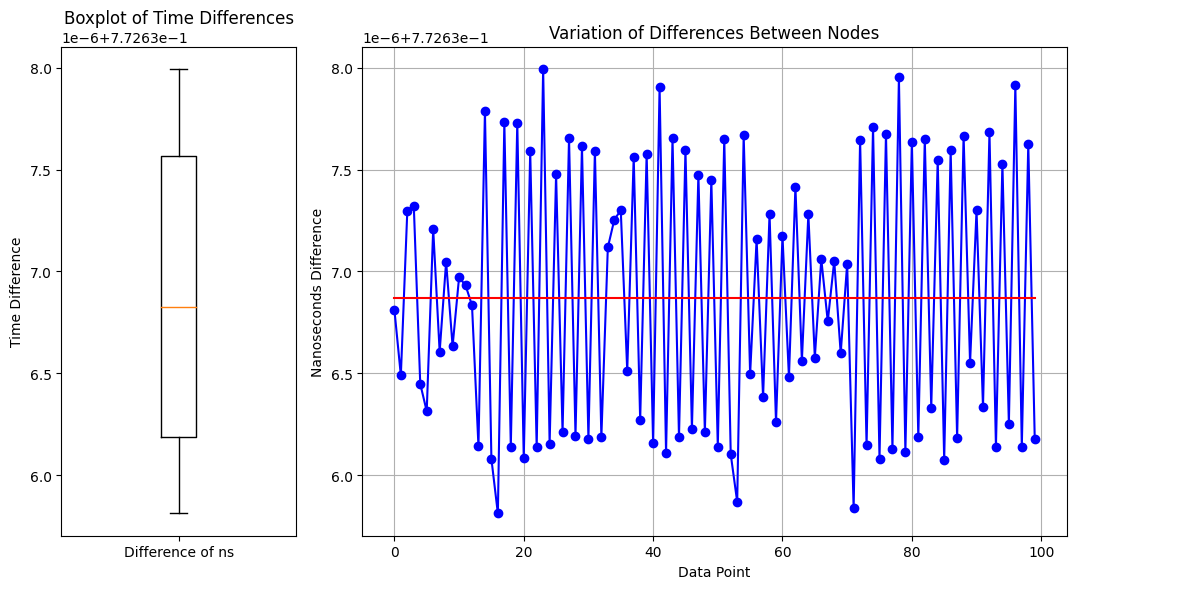

In [2]:
import matplotlib.gridspec as gridspec
# Host r507c06n04  , Rank 001: seconds 1357236, nanosecond 136250940
# Host r507c06n01  , Rank 000: seconds 1357226, nanosecond 50537229
pattern=r'Host (\w+)  , Rank (\d+): seconds (\d+), nanosecond (\d+)'
skew_data =defaultdict(list)
hosts=[]
file_path= os.path.join(base_dir,f'timeshift.data')
with open(file_path, 'r') as file: 
        for line in file:
            match = re.search(pattern, line)
            if match:
                host,_,second,nanosecond = match.groups()
                skew_data[host].append((int(second), int(nanosecond)))
                if host not in hosts :hosts.append(host)
print(hosts)

differences = []
differences_second =[]

for (sec1, ns1), (sec2, ns2) in zip(skew_data[hosts[0]], skew_data[hosts[1]]):
    diff_sec = sec2 - sec1
    diff_ns = ns2 - ns1
    if diff_ns < 0:
        diff_sec -= 1
        diff_ns += 1000000000
    differences.append((diff_ns/1e9))
    differences_second.append((diff_sec))
    
print(differences_second[0],np.average(differences_second)) 
print(max(differences),min(differences))
print(max(differences)-min(differences))

average=[np.average(differences)]

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 3, 0.2])
ax1 = plt.subplot(gs[0])
ax1.boxplot([differences], labels=['Difference of ns'])
ax1.set_title('Boxplot of Time Differences')
ax1.set_ylabel('Time Difference')
ax2 = plt.subplot(gs[1])
ax2.plot(differences, marker='o', linestyle='-', color='b')
ax2.plot(average*len(differences),color="red")
ax2.set_title('Variation of Differences Between Nodes')
ax2.set_xlabel('Data Point')
ax2.set_ylabel('Nanoseconds Difference')
ax2.grid(True)
ax3 = plt.subplot(gs[2])
ax3.axis('off')
plt.tight_layout()
plt.show()

(array([ 3., 27.,  8., 10.,  3.,  7., 10.,  6., 21.,  5.]),
 array([0.77263581, 0.77263603, 0.77263625, 0.77263647, 0.77263669,
        0.7726369 , 0.77263712, 0.77263734, 0.77263756, 0.77263778,
        0.772638  ]),
 <BarContainer object of 10 artists>)

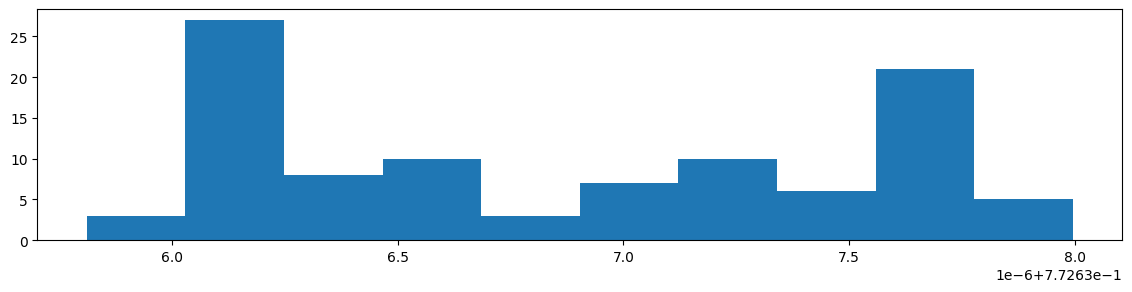

In [3]:
fig = plt.figure(figsize=(14, 3))
plt.hist(differences)

In [4]:
sec_diff= statistics.mean(differences_second)
mode=statistics.mean(differences)
sec=skew_data[hosts[0]][0][0]+sec_diff

if skew_data[hosts[0]][0][1]+mode*1e9 > 1e9: ns=skew_data[hosts[0]][0][1]+mode*1e9-1e9;sec+=1#; print("+1s")
else: ns=skew_data[hosts[0]][0][1]+mode*1e9#; print("+0s")
print(f'Difference {hosts[0]} - {hosts[1]} :{(sec_diff,mode*1e9)}\n{hosts[0]}: {skew_data[hosts[0]][0]}\n{hosts[1]}: ({sec},{ns})')

Difference r507c01n03 - r507c02n02 :(-1, 772636867.81)
r507c01n03: (2135776, 849987497)
r507c02n02: (2135776,622624364.81)


In [5]:
# udp] pub_s = 17180379 pubns = 527983166 sub_s = 26271606 subns = 201584761
pub_s = 2135776 
pubns = 622623683.0 
sub_s = 2135776 
subns = 849987497 #849987442.19


def timespec_difference_without_skew(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# get difference in timespec
def timespec_difference(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s,subns, end_s_un, end_ns_un)

    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

## Retrive data

In [6]:
# for file_path in pub_matching_files:

sent_data={}
received_data={}
sent_data_time={}
for prot in protocols:
    sent_data[prot]={}
    received_data[prot]={}
    sent_data_time[prot]={}
    for seq in sequence:
        sent_data[prot][seq]=[]
        received_data[prot][seq]=[]
        sent_data_time[prot][seq]=[]

for files in matching_files:
    match_file = re.search(file_pattern, files)
    if match_file:
        actor,protocol,testN,subIndex = match_file.groups()
        if actor == "pub": #pubs
            with open(files, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[protocol][int(testN)].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                        s_diff, ns_diff = timespec_difference_without_skew(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                        sent_data_time[protocol][int(testN)].append((s_diff, ns_diff))
        else: # subs
            with open(files, 'r') as file: 
                for content in file:
                    match = re.search(sub_pattern, content)
                    if match:
                        line_n, received_s, received_ns = match.groups()
                        start_s,start_ns = ((sent_data[protocol][int(testN)][int(line_n)][2], sent_data[protocol][int(testN)][int(line_n)][3]))
                        if protocol == "shm":s_diff, ns_diff = timespec_difference_without_skew(start_s, start_ns , int(received_s), int(received_ns))
                        else:s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                        received_data[protocol][int(testN)].append((s_diff, ns_diff))


### Cleaning data

In [7]:
column_time = {}
column_time_avg ={}
column_time_cleaned = {}
for prots in protocols:
    column_time[prots]={}
    column_time_cleaned[prots]={}
    column_time_avg[prots]={}
    for seq in sequence:
        list_difference=[]
        nlen= len(received_data[prots][seq])
        for cycle_data in received_data[prots][seq]:
            difference=cycle_data[0] * 1e6 + cycle_data[1] / 1e3
            list_difference.append(difference) # time in microsecond
        column_time[prots][seq]=list_difference
        #clean data
        try:
            lower_bound, upper_bound = calculate_iqr(column_time[prots][seq])
            column_time_cleaned[prots][seq] = [x for x in column_time[prots][seq] if lower_bound <= x <= upper_bound]
            column_time_avg[prots][seq]=np.average(column_time_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass
    
column_timesent = {}
column_timesent_avg ={}
column_timesent_cleaned = {}
for prots in protocols:
    column_timesent[prots]={}
    column_timesent_cleaned[prots]={}
    column_timesent_avg[prots]={}
    for seq in sequence:
        list_difference=[]
        nlen= len(sent_data_time[prots][seq])
        for cycle_data in sent_data_time[prots][seq]:
            difference=cycle_data[0] * 1e6 + cycle_data[1] / 1e3
            list_difference.append(difference) # time in microsecond
        column_timesent[prots][seq]=list_difference
        #clean data
        try:
            lower_bound, upper_bound = calculate_iqr(column_timesent[prots][seq])
            column_timesent_cleaned[prots][seq] = [x for x in column_timesent[prots][seq] if lower_bound <= x <= upper_bound]
            column_timesent_avg[prots][seq]=np.average(column_timesent_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass

# Sending-receive

### Sequence 1: only 1 pub 1 sub

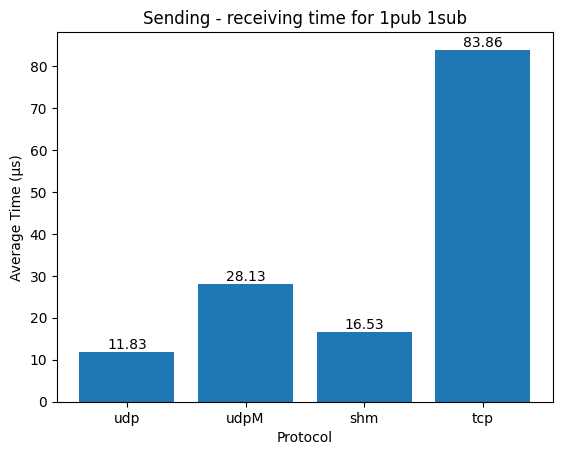

In [8]:
sequence_to_compare = 1
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()

bars = ax.bar(protocols, average_times)

for bar, value in zip(bars, average_times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{value:.2f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Average Time (μs)')
plt.savefig(f"{base_save_dir_thesis}test3_bar_sr_1p1s.png")
ax.set_title(f'Sending - receiving time for 1pub 1sub')
plt.savefig(f"{base_save_dir}test3_bar_sr_1p1s.png")


plt.show()


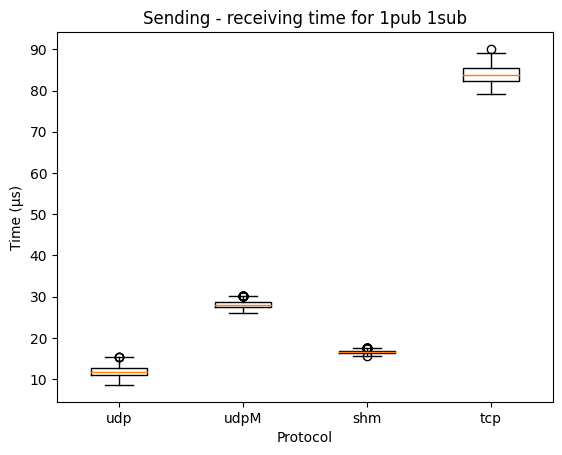

In [9]:
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()

ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Time (μs)')
ax.set_title(f'Sending - receiving time for 1pub 1sub')
plt.show()



### All sequence

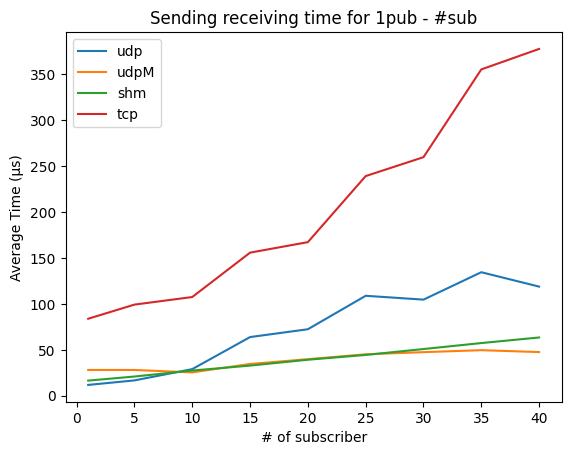

In [10]:
avg_data = {prots: [column_time_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (μs)')
ax.legend()
plt.savefig(f"{base_save_dir_thesis}test3_sendingreceiving_multiplesub.png")
ax.set_title('Sending receiving time for 1pub - #sub')
plt.savefig(f"{base_save_dir}test3_sendingreceiving_multiplesub.png")


plt.show()

### udp vs udpM

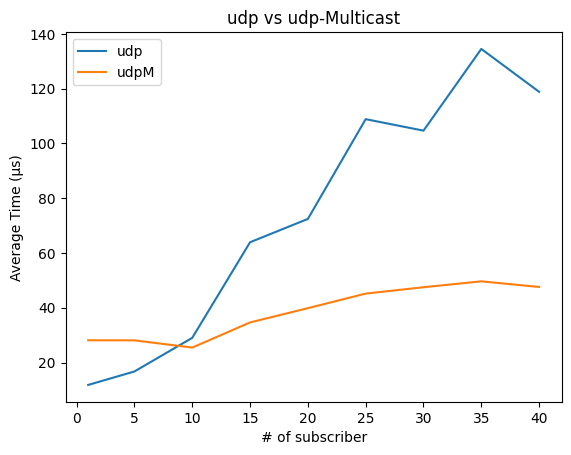

In [11]:
avg_data = {prots: [column_time_avg[prots][seq] for seq in sequence] for prots in ["udp","udpM"]}

fig, ax = plt.subplots()
for prots in ["udp","udpM"]:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (μs)')
ax.legend()
plt.savefig(f"{base_save_dir_thesis}test3_udpvsudpM.png")

ax.set_title('udp vs udp-Multicast')
plt.savefig(f"{base_save_dir}test3_udpvsudpM.png")



plt.show()

# Only send


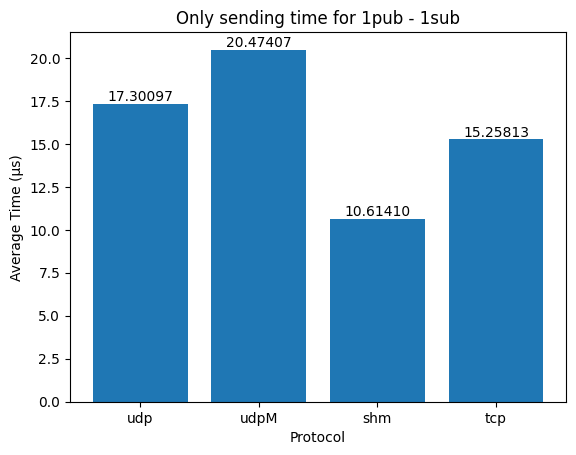

In [12]:
sequence_to_compare = 1
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()

bars = ax.bar(protocols, average_times)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Average Time (μs)')
plt.savefig(f"{base_save_dir_thesis}test3_sending_1sub.png")
ax.set_title(f'Only sending time for 1pub - 1sub')
plt.savefig(f"{base_save_dir}test3_sending_1sub.png")



plt.show()

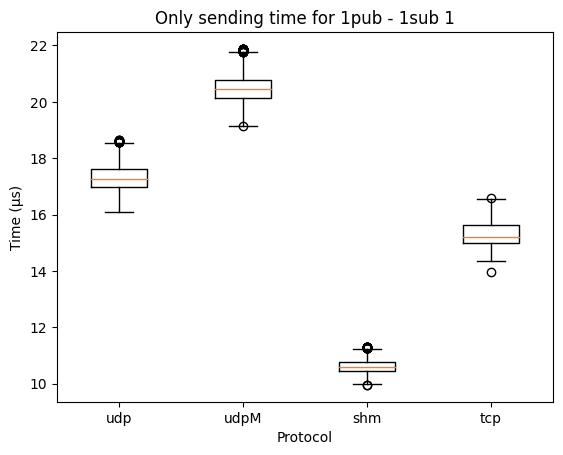

In [13]:
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()

ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Time (μs)')
ax.set_title(f'Only sending time for 1pub - 1sub {sequence_to_compare}')
plt.show()        

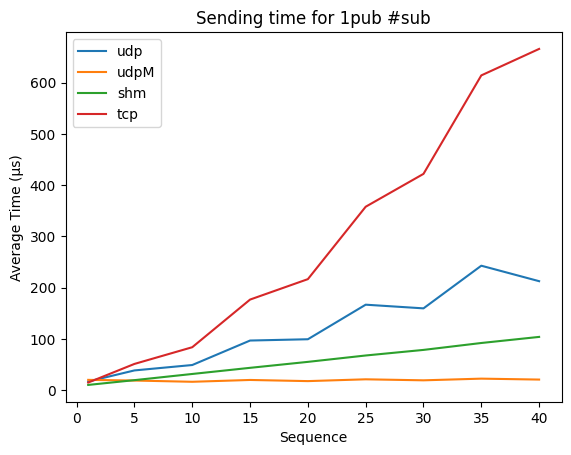

In [14]:
avg_data = {prots: [column_timesent_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('Sequence')
ax.set_ylabel('Average Time (μs)')
ax.legend()
plt.savefig(f"{base_save_dir_thesis}test3_sending_multiplesub.png")
ax.set_title('Sending time for 1pub #sub')


plt.savefig(f"{base_save_dir}test3_sending_multiplesub.png")



plt.show()

# Protocol in-depth analysis

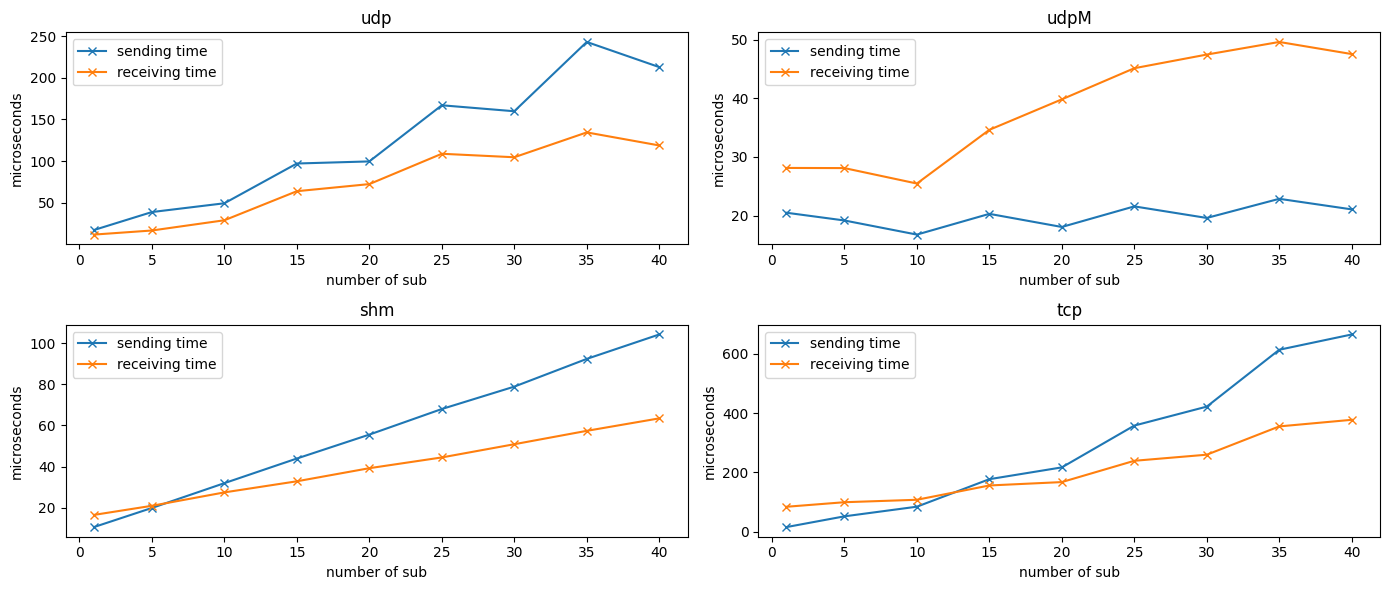

In [15]:
sent_avg={}
time_avg={}

for prot in protocols:
    sent_avg[prot] = [column_timesent_avg[prot][seq] for seq in sequence]
    time_avg[prot] = [column_time_avg[prot][seq] for seq in sequence]

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2)
for i,prot in enumerate(protocols):
    ax = plt.subplot(gs[i])
    ax.set_title(prot)
    ax.plot(sequence, sent_avg[prot], label='sending time', marker='x')
    ax.plot(sequence, time_avg[prot], label='receiving time', marker='x')
    ax.set_xlabel('number of sub')
    ax.set_ylabel('microseconds')
    ax.legend()

plt.savefig(f"{base_save_dir}test3_different_protocol_send_receive.png")
plt.savefig(f"{base_save_dir_thesis}test3_different_protocol_send_receive.png")


plt.tight_layout()
plt.show()

# Troughput

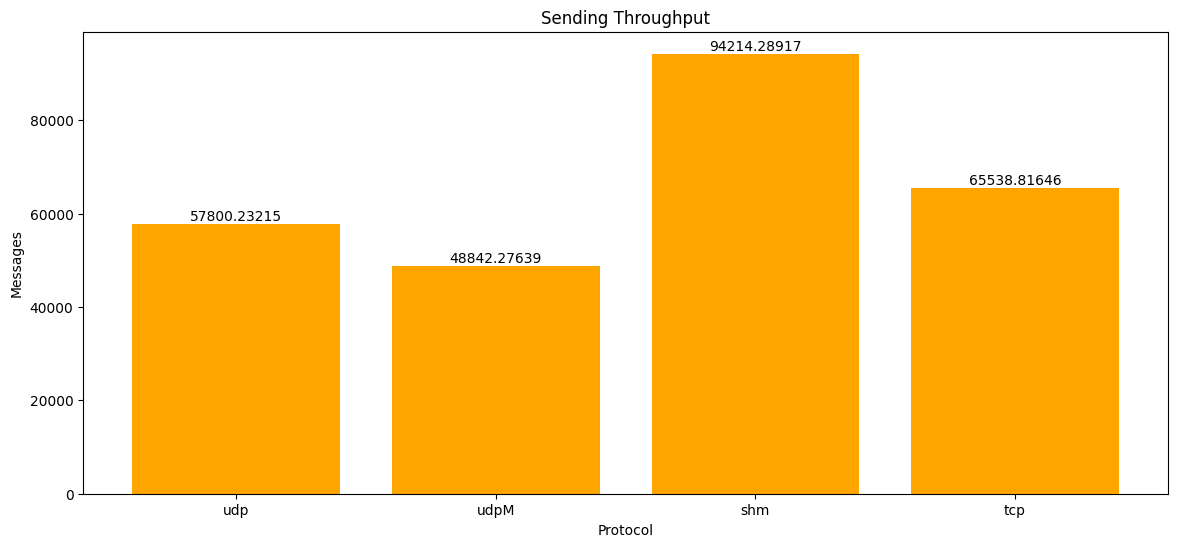

In [16]:
throughput_send={}
throughput_receive={}
for prot in protocols:
    throughput_send[prot]= 1/column_timesent_avg[prot][1] * 1e6 # it was on microseconds
    throughput_receive[prot] =  1/column_time_avg[prot][1] * 1e6 # it was on microseconds]

fig = plt.figure(figsize=(14, 6))
ax = plt.subplot()
ax.set_xlabel('Protocol')
ax.set_ylabel('Messages')

data_to_compare = {prots: throughput_send[prots] for prots in protocols}
average_times = [np.mean(data_to_compare[prots]) for prots in protocols] 
bars = ax.bar(protocols, average_times,color="orange")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
plt.savefig(f"{base_save_dir_thesis}test3_throughput.png")
ax.set_title(f'Sending Throughput')
plt.savefig(f"{base_save_dir}test3_throughput.png")


plt.show()